In [1]:
import time
import torch
import cv2
import os
import json
import csv
import math
from math import exp, sqrt, pi, floor
import seaborn as sns
import random
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline

# Generating heatmaps

In [ ]:
def _gaussian(
        size=3, sigma=0.25, amplitude=1, normalize=False, width=None,
        height=None, sigma_horz=None, sigma_vert=None, mean_horz=0.5,
        mean_vert=0.5):
    # handle some defaults
    if width is None:
        width = size
    if height is None:
        height = size
    if sigma_horz is None:
        sigma_horz = sigma
    if sigma_vert is None:
        sigma_vert = sigma
    center_x = mean_horz * width + 0.5
    center_y = mean_vert * height + 0.5
    gauss = np.empty((height, width), dtype=np.float32)
    # generate kernel
    for i in range(height):
        for j in range(width):
            gauss[i][j] = amplitude * math.exp(-(math.pow((j + 1 - center_x) / (
                sigma_horz * width), 2) / 2.0 + math.pow((i + 1 - center_y) / (sigma_vert * height), 2) / 2.0))
    if normalize:
        gauss = gauss / np.sum(gauss)
    return gauss

In [ ]:
def hm_from_lm(image, point, sigma):
        ul = [math.floor(point[0] - 3 * sigma), math.floor(point[1] - 3 * sigma)]
        br = [math.floor(point[0] + 3 * sigma), math.floor(point[1] + 3 * sigma)]
        if (ul[0] > image.shape[1] or ul[1] >
                image.shape[0] or br[0] < 1 or br[1] < 1):
            return image
        size = 6 * sigma + 1
        g = _gaussian(size)
        g_x = [int(max(1, -ul[0])), int(min(br[0], image.shape[1])) -
               int(max(1, ul[0])) + int(max(1, -ul[0]))]
        g_y = [int(max(1, -ul[1])), int(min(br[1], image.shape[0])) -
               int(max(1, ul[1])) + int(max(1, -ul[1]))]
        img_x = [int(max(1, ul[0])), int(min(br[0], image.shape[1]))]
        img_y = [int(max(1, ul[1])), int(min(br[1], image.shape[0]))]
        assert (g_x[0] > 0 and g_y[1] > 0)
        image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]
              ] = image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]] + g[g_y[0] - 1:g_y[1], g_x[0] - 1:g_x[1]]
        image[image > 1] = 1
        return image

In [ ]:
def get_img_center_and_radius(img_name):
    eye_centers = {}
    with open('crowdpupil/results.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=';')
        for row in spamreader:
            eye_centers[row[0]] = (int(row[1]), int(row[2]))
            
    with open('crowdpupil/eye_radius.json', 'r') as fp:
        eye_radius = json.load(fp)
            
    return (eye_centers[img_name], sum(eye_radius.values())/len(eye_radius))

In [ ]:
eye_images = os.listdir('./crowdpupil/images')

In [ ]:
img_name = random.choice(eye_images)
img = cv2.imread('./crowdpupil/images/' + img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

In [ ]:
def generate_heatmap_from_img (img_name):
    img = cv2.imread('crowdpupil/images/' + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    center, radius = get_img_center_and_radius(img_name)

    m1 = center
    s1 = np.eye(2) * radius ** 1.5
    k1 = multivariate_normal(mean=m1, cov=s1)

    # create a grid of (x,y) coordinates at which to evaluate the kernels
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    xx, yy = np.meshgrid(x,y)

    # evaluate kernels at grid points
    xxyy = np.c_[xx.ravel(), yy.ravel()]
    zz = k1.pdf(xxyy)

    # reshape and plot image
    heatmap = zz.reshape(img.shape)
    a = heatmap * 255 / np.amax(heatmap)
    cv2.imwrite('crowdpupil/heatmaps/h_' + img_name, heatmap * 255 / np.amax(heatmap))

In [ ]:
os.makedirs('crowdpupil/heatmaps', exist_ok=True)
for index, img in enumerate(eye_images):
    generate_heatmap_from_img(img)
    if index % 50 == 0:
        print (f'Done {index}/{len(eye_images)}')

# Use AutoEncoder with the heatmaps 

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [47]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load all of the heatmaps
h_list = os.listdir('./crowdpupil/heatmaps')
all_data = []
for index, h in enumerate(h_list):
    if index % 100 == 0:
        print (f'Done {index}/{len(all_data)}')
    img = cv2.imread('./crowdpupil/heatmaps/' + h, cv2.IMREAD_GRAYSCALE)
    # resize the image to a fixed dimension
    img = cv2.resize(img, (1000//2, 776//2), interpolation=cv2.INTER_AREA)
    img = img.reshape(1, 776//2, 1000//2)
    img = img/255
    img = torch.from_numpy(img).float()
    all_data.append(img)
    
print (len(all_data))

Done 0/0
Done 100/100
Done 200/200
Done 300/300
Done 400/400
Done 500/500
Done 600/600
Done 700/700
792


In [48]:
# split train test
random.shuffle(all_data)
split_size = 0.8
train_size = int(len(all_data) * split_size)
train_data = all_data[:train_size]
test_data = all_data[train_size:]

print (len(train_data))

633


In [49]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## Visualise the data

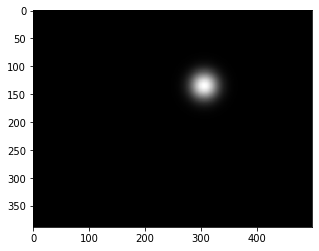

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(random.choice(images))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [51]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [52]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    start_time = time.time()
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f} \t Training time: {:.6f}'.format(
        epoch, 
        train_loss,
        time.time() - start_time
        ))

Epoch: 1 	Training Loss: 8.534450 	 Training time: 71.007151
Epoch: 2 	Training Loss: 7.990970 	 Training time: 65.348957
Epoch: 3 	Training Loss: 7.129950 	 Training time: 67.596570
Epoch: 4 	Training Loss: 5.663889 	 Training time: 70.278433
Epoch: 5 	Training Loss: 3.615065 	 Training time: 65.649640
Epoch: 6 	Training Loss: 1.718863 	 Training time: 63.578554
Epoch: 7 	Training Loss: 0.641477 	 Training time: 64.131327
Epoch: 8 	Training Loss: 0.254209 	 Training time: 84.414018
Epoch: 9 	Training Loss: 0.129183 	 Training time: 66.019002
Epoch: 10 	Training Loss: 0.079587 	 Training time: 65.703435


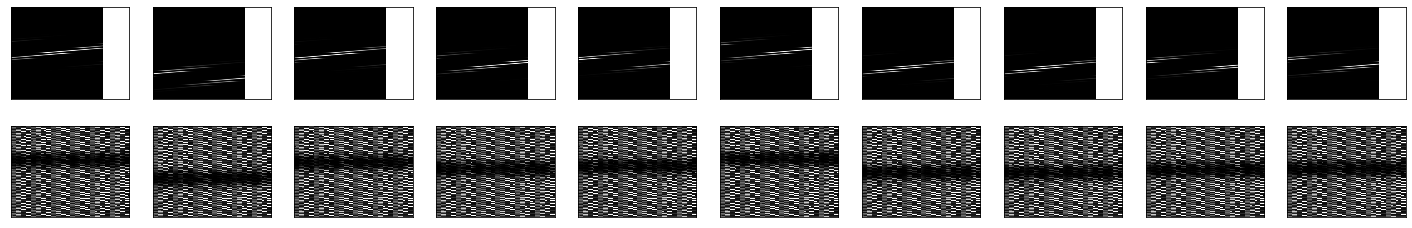

In [33]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 776//2, 1000//2)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
plt.imshow(output[0].reshape(776, 1000) * 255, cmap='gray')